In [747]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, chi2
import numpy as np
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import PowerTransformer, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier
)
from lightgbm import LGBMClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import pickle

warnings.filterwarnings("ignore")

In [748]:
# Load data
excel_file_path = "./train.csv"
df = pd.read_csv(excel_file_path, encoding="latin-1")
df = pd.DataFrame(df)

In [749]:
def extract_first_last(df):
    df[['deck', 'num', 'side']] = df['Cabin'].str.split('/', expand=True)
    # df['group'] = df['PassengerId'].str[:4]
    return df

df = extract_first_last(df)
df.columns
df = df.drop_duplicates()

In [750]:
# Define features and target
def get_X_Y(df):
    X = df.drop(columns=["PassengerId", "Name", "Transported", "Cabin", "num"]) # , "num", "side"
    Y = df["Transported"]
    return X, Y

X, Y = get_X_Y(df)

In [751]:
# Split data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=5)
# Check columns
print(X_train.columns, X_train.shape)

Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'deck', 'side'],
      dtype='object') (6954, 12)


In [752]:
# Get the list of numerical column names
numerical_features = X_train.select_dtypes(include=[np.number]).columns.tolist()

# Get the list of categorical column names
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

In [753]:
X_train.isnull().sum()

HomePlanet      156
CryoSleep       170
Destination     145
Age             132
VIP             172
RoomService     152
FoodCourt       148
ShoppingMall    175
Spa             152
VRDeck          149
deck            157
side            157
dtype: int64

In [754]:
def show_graph(col_list):
    for feature in col_list:
        plt.figure(figsize=(14, 4))
        plt.subplot(121)
        sns.histplot(X_train[feature], kde=True, stat="density", log_scale=False)
        plt.title(f"{feature} after bining")
        plt.show()

# show_graph(numerical_features)

In [755]:
# Get unique elements for each column
for x in categorical_features:
    print(x, X_train[x].unique(), len(X_train[x].unique()))

HomePlanet ['Europa' 'Earth' 'Mars' nan] 4
CryoSleep [False True nan] 3
Destination ['55 Cancri e' 'TRAPPIST-1e' nan 'PSO J318.5-22'] 4
VIP [False nan True] 3
deck ['C' 'F' 'D' 'E' 'G' 'B' nan 'A' 'T'] 9
side ['P' 'S' nan] 3


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

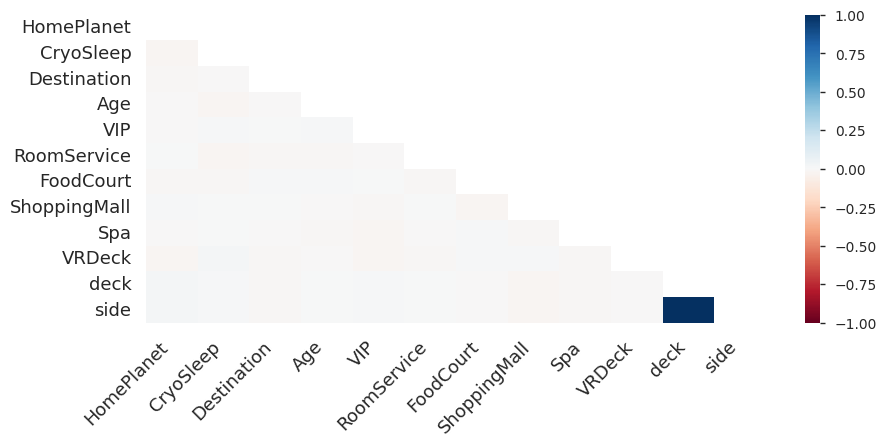

In [756]:
import pandas as pd
from pandas_profiling import ProfileReport
def gen_eda():
    profile = ProfileReport(pd.concat([X_train, Y_train], axis=1), title='Pandas Profiling Report', explorative=True)
    profile.to_file("pandas_profiling_report.html")
gen_eda()

In [757]:
# Separate transformers for categorical and numerical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', KNNImputer()),
    ('scaler', StandardScaler()),
    ('power', PowerTransformer())
])

In [758]:
# Combine into a single ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numerical_transformer, numerical_features)
    ]
)

# Define model
model = RandomForestClassifier()

# Define the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

In [759]:
# Fit the pipeline on the training data
pipeline.fit(X_train, Y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['HomePlanet', 'CryoSleep',
                                                   'Destination', 'VIP', 'deck',
                                                   'side']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('power',
                                                                   PowerTransformer())]),
                                                  ['Age', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck'])])),
                ('model', RandomForestClassifier())])

In [760]:
# Save the fitted pipeline as a .pkl file
filename_pkl = "model.pkl"
pickle.dump(pipeline, open(filename_pkl, "wb"))
print(f"Model saved as {filename_pkl}")

Model saved as model.pkl


In [761]:
# Evaluate the model
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7918343875790684


In [762]:
from sklearn.model_selection import cross_val_score

cross_val_score(pipeline, X_test, Y_test, cv=5, scoring="accuracy").mean()

0.7722995130676737

In [763]:
import pandas as pd
import numpy as np
import pickle

# Load the trained model
loaded_model = pickle.load(open('model.pkl', "rb"))

# Define the columns expected by the model
column_names = X_train.columns

def generate_submission(test_file):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(test_file)
    df = pd.DataFrame(df)
    # Replace empty strings with NaN
    df.replace('', np.nan, inplace=True)
    df = extract_first_last(df)
    # Select the relevant columns
    filtered_df = df[column_names]
    predictions = pipeline.predict(filtered_df)
    # Load the original test file to keep the PassengerId column
    original_df = pd.read_csv(test_file)
    original_df['Transported'] = predictions
    # Save the results to a new CSV file
    submission_df = original_df[['PassengerId', 'Transported']]
    submission_df.to_csv('submission.csv', index=False)
    print("Submission file saved as 'submission.csv'")


# Generate the submission
test_file = 'test.csv'
generate_submission(test_file)

Submission file saved as 'submission.csv'
